In [ ]:
#|default_exp flattening.radial_ae
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import torch

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

False

# Radial Flattening Autoencoder
> A cousin of the Geodesic AE that learns the logarithmic map from a manifold neighborhood to its tangent space.

The fairly popular Geodesic autoencoder is attempting to do something fundamentally impossible. By taking an entire manifold and trying to force manifold distances to match Euclidean distances, even in the manifold's intrinsic dimension, you are demanding a geometric absurdity. The sphere is two-dimensional, yet there is no set of points in Euclidean 2-space that can capture its geometry. That's why it's a sphere.

For diffusion curvature, we want to do something similar, but actually possible. Specifically, we only want to transfer a neighborhood around a point into the Euclidean space tangent to that point, in such a way that the neighborhood is flattened, while preserving as much of the original sampling as possible.

The ideal flattening of $N(x) \in M$ has

1. Radial distances $d_{M}(x, y)=d_{E}(\varphi(x), \varphi(y))$ $\forall y \in M$. This is the primary objective.
2. Neighborhoods of each $y$ should be roughly preserved, ie. $K L D\left(A_{E}, A_{\mu}\right)$ $<\varepsilon$.
3. The space should be flat, egg. MMD $(\varphi(x)$. $\left.\mathbb{R}^{\sigma}\right)<\varepsilon$.

With this radial flattening autoencoder, we encode objectives 1 and 2. We'll evaluate the effectiveness of these two alone, and expect to combine them with objective 3 in the form of MIOFlow.

# Implementation

Doing this effectively will require two pieces, a PyTorch model and a custom PyTorch dataset which encodes radial distances and nearest neighbour affinities. The latter may require that batching be modified so that each batch contains points drawn from the local neighborhood. But we're going to start out with normal, random batching.


## Datasets & Stuff

In [ ]:
#|export
import torch
from diffusion_curvature.kernels import median_heuristic

class RadialDistancesDataset(torch.utils.data.Dataset):
    """
    Given a pointcloud, a distance matrix, and a central idx
    returns a dataloader with keys
    x - points per batch, beginning with central idx (which appears in every batch)
    d - distances to central idx in batch
    a - local adjacency matrix of batch, exp(-d)
    """
    def __init__(self, pointcloud, distances, central_idx, batch_size = 64, sigma=None):
        self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
        self.distances = torch.tensor(distances, dtype=torch.float32)
        self.distances = self.distances / torch.max(self.distances)
        self.central_idx = central_idx
        self.batch_size = batch_size
        if sigma is None:
            sigma = median_heuristic(self.distances)
        self.sigma = sigma

    def __len__(self):
        return len(self.pointcloud)
    
    def __getitem__(self, idx):
        batch_idxs = torch.concatenate([torch.tensor([self.central_idx]),torch.randperm(len(self.pointcloud))[:self.batch_size-1]])
        batch = {}
        batch['x'] = self.pointcloud[batch_idxs]
        batch['d'] = self.distances[self.central_idx][batch_idxs]
        a = torch.exp(-self.distances[batch_idxs][:,batch_idxs]**2/(2*self.sigma**2))
        batch['p'] = a / torch.sum(a, axis=-1)[:,None]
        return batch
        
def dataloader_for_local_neighborhood_flattening(pointcloud, distances, central_idx, batch_size = 64):
    dataset = RadialDistancesDataset(pointcloud, distances, central_idx, batch_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=True)
    return dataloader

# We don't expect to have enough points for this to be useful.
# def train_and_testloader_from_pointcloud_with_distances(
#     pointcloud, distances, batch_size = 64, train_test_split = 0.8
# ):
#     X = pointcloud
#     D = distances
#     split_idx = int(len(X)*train_test_split)
#     X_train = X[:split_idx]
#     X_test = X[split_idx:]
#     D_train = D[:split_idx,:split_idx]
#     D_test = D[split_idx:,split_idx:]
#     trainloader = dataloader_from_pointcloud_with_distances(X_train, D_train, batch_size)
#     testloader = dataloader_from_pointcloud_with_distances(X_test, D_test, batch_size)
#     return trainloader, testloader

Testing the above

In [ ]:
# example 
from diffusion_curvature.datasets import torus
from heatgeo.embedding import HeatGeo
import numpy as np

In [ ]:
X_torus, ks = torus(2000, use_guide_points = True, )
emb_op = HeatGeo(knn=5)
emb = emb_op.fit_transform(X_torus)
D_torus = emb_op.dist
# create dataset
dataloader = dataloader_for_local_neighborhood_flattening(X_torus, D_torus, central_idx=0, batch_size=64)
# test dataloader
for b in dataloader:
    test_eq(b['x'].shape, [64,3])
    test_eq(b['x'][0],X_torus[0])
    assert torch.allclose(b['p'].sum(1), torch.ones(64,dtype=torch.float32))

/home/piriac/mambaforge/envs/diffusion-curvature-jax/lib/python3.11/site-packages/graphtools/base.py:165: RuntimeWarning:

Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 3



KeyboardInterrupt: 

## Model

In [ ]:
#|export
import torch
import torch.nn as nn
import pytorch_lightning as pl

class RadialFlatteningAutoencoder(pl.LightningModule):
    """
    What if you already know what your latent space should look like, but want to learn a differentiable mapping into it?
    Enter the DistanceMatchingAutoencoder, or DISMA for short. In addition to a mean squared error loss, it also penalizes the difference between the pairwise distances of the embedding and the supplied ground truth.

    Each minibatch from the dataloader is assumed to have the following keys:
    - `x`: the input data
    - `d`: the ground truth manifold distances from each batch point to the central point
    - 'p': a local diffusion matrix
    """
    def __init__(self, input_dim, intrinsic_dim, learning_rate=1e-3, reconstruction_weight=1, distance_weight=1, affinity_weight = 1, sigma=5):
        super().__init__()
        self.input_dim = input_dim
        self.intrinsic_dimension = intrinsic_dim
        self.lr = learning_rate
        self.reconstruction_weight = reconstruction_weight
        self.distance_weight = distance_weight
        self.affinity_weight = affinity_weight
        self.KLD = nn.KLDivLoss(reduction="batchmean")
        self.sigma = sigma
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=intrinsic_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=intrinsic_dim, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self,x):
        return self.encoder(x)
    
    def immersion(self, x):
        """The immersion defined by the autoencoder (or more precisely, the decoder)."""
        return self.decoder(x)

    def distance_loss(self, x_embedded, ground_truth_distances):
        # print("x_embedded is ", x_embedded)
        embedding_distances = torch.cdist(x_embedded, x_embedded[None,]) # torch.sqrt(torch.sum((x_embedded - x_embedded[0])**2, axis=-1)) # TODO: How will this play with batching?
        # print(embedding_distances)
        loss = nn.MSELoss()(embedding_distances, ground_truth_distances)
        # print(loss)
        return loss

    def affinity_loss(self, x_embedded, ground_truth_affinities):
        D = torch.cdist(x_embedded, x_embedded)
        A = torch.exp(-D**2/(2*self.sigma**2)) + torch.ones_like(D)*1e-10 #+ torch.eye(x_embedded.shape[0], device=x_embedded.device) + 1e-10
        P = A / torch.sum(A, axis=-1)[:,None]
        # KLD expects the input to be log'd
        Plog = torch.log(P)
        # test if there's a nan in Plog
        # print(torch.isnan(Plog).any().item())
        return self.KLD(Plog,ground_truth_affinities+torch.ones_like(D)*1e-10) #+  torch.eye(x_embedded.shape[0], device=x_embedded.device) + 1e-10)       )

    def step(self, batch, batch_idx):
        x = batch['x']
        d = batch['d']
        p = batch['p']
        x_embedded = self.encoder(x)
        x_hat = self.decoder(x_embedded)
        recon_loss = nn.MSELoss()(x_hat, x) if self.reconstruction_weight else 0
        dist_loss = self.distance_loss(x_embedded, d) if self.distance_weight else 0
        affinity_loss = self.affinity_loss(x_embedded, p) if self.affinity_weight else 0
        # print(f"{recon_loss=}, {dist_loss=}, {affinity_loss=}")
        loss = self.reconstruction_weight * recon_loss + self.distance_weight * dist_loss + self.affinity_weight * affinity_loss
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [ ]:
# check that affinity loss is doing the right thing
RFAE = RadialFlatteningAutoencoder(input_dim=3,intrinsic_dim=2, sigma=5)

In [ ]:
#|export
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

def radially_flatten_with_ae(
    X,
    D = None, # if not supplied, computes with heatgeo
    learning_rate = 1e-5,
    intrinsic_dim = 2,
    return_model = False,
    affinity_weight=1,
    central_idx = 0,
    max_epochs = 20,
    sigma=0.5,
    device='cpu',
):
    if D is None:
        emb_op = HeatGeo(knn=5)
        emb = emb_op.fit_transform(X)
        D = emb_op.dist
        
    trainloader = dataloader_for_local_neighborhood_flattening(X, D, central_idx=central_idx, batch_size=64)
    train_sample = next(iter(trainloader))
    
    # Initialize model and trainer
    model = RadialFlatteningAutoencoder(
        input_dim = train_sample['x'].shape[1],
        intrinsic_dim = intrinsic_dim,
        reconstruction_weight = 0,
        distance_weight = 1,
        affinity_weight = affinity_weight,
        learning_rate = learning_rate,
        sigma=sigma,
        )

    trainer = Trainer(
        max_epochs=max_epochs, 
        accelerator=device,
        use_distributed_sampler=False,
        enable_progress_bar=True, enable_model_summary=False,
        )
    trainer.fit(
        model=model,
        train_dataloaders=trainloader,        
    )
    embeddings = model.encoder(trainloader.dataset.pointcloud).cpu().detach().numpy()
    if return_model: return embeddings, model
    else: return embeddings
    

# Tests

## Spheres

For testing in this notebook, we'll prepare a list of local neighborhoods around each point of the torus.

In [ ]:
X_torus, ks = torus(10000,use_guide_points=True)

In [ ]:
import numpy as np
def k_nearest_neighbors(X, i, k):
    # Calculate the Euclidean distance
    distances = np.linalg.norm(X - X[i], axis=1)
    # Get the sorted indices based on the distances
    sorted_indices = np.argsort(distances)
    # Return the indices of the k nearest neighbors excluding the point itself
    return sorted_indices[1:k+1]
    
torus_neighborhoods = [
       X_torus[k_nearest_neighbors(X_torus,i,400)] for i in range(X_torus.shape[0])
]

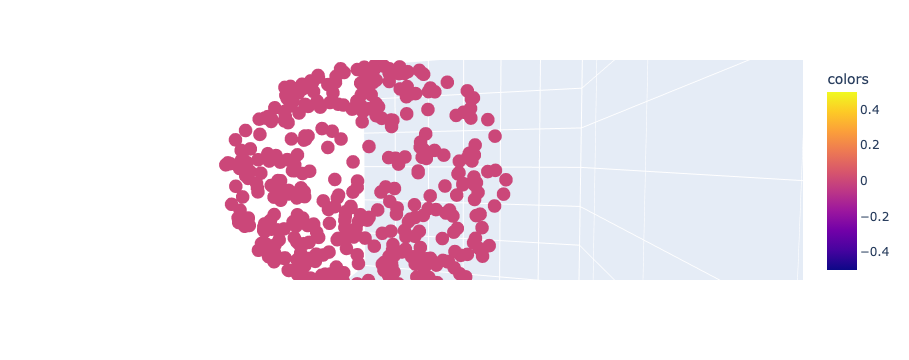

In [ ]:
plot_3d(torus_neighborhoods[0],use_plotly=True)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
i = 0
X_train = torus_neighborhoods[i][:len(torus_neighborhoods[i])//2]
emb_op = HeatGeo(knn=5)
emb = emb_op.fit_transform(X_train)
D_train = emb_op.dist

X_test = torus_neighborhoods[i][len(torus_neighborhoods[i])//2:]
emb_op = HeatGeo(knn=5)
emb = emb_op.fit_transform(X_test)
D_test = emb_op.dist

trainloader = dataloader_for_local_neighborhood_flattening(X_train, D_train, central_idx=0, batch_size=64)
testloader = dataloader_for_local_neighborhood_flattening(X_test, D_test, central_idx=0, batch_size=64)

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


In [ ]:
train_sample = next(iter(trainloader))
# Initialize model and trainer
model = RadialFlatteningAutoencoder(
    input_dim = train_sample['x'].shape[1],
    intrinsic_dim = 2,
    reconstruction_weight = 1,
    distance_weight = 1,
    affinity_weight = 1,
    learning_rate = 1e-5
    )
early_stopping = EarlyStopping('val_loss', patience=100)
trainer = Trainer(
    max_epochs=100, 
    accelerator='cuda',
    # callbacks=],
    use_distributed_sampler=False
    )
trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    # val_dataloaders=testloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | KLD     | KLDivLoss  | 0     
1 | encoder | Sequential | 42.3 K
2 | decoder | Sequential | 42.3 K
---------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)


Training: |                                                                                                   …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.


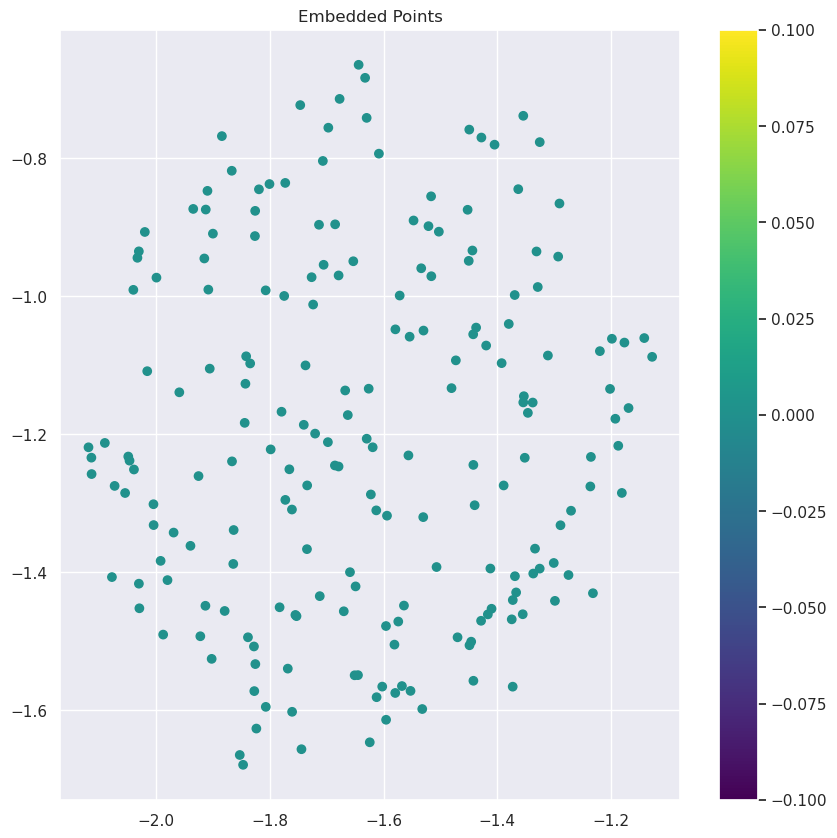

In [ ]:
visualize_embedding(model, trainloader)

With the function:

In [ ]:
# compute set of neighborhoods: spheres and saddles
neighbs = []
n_points_per_ds = 500
sphere_radii = [1,2,3,4,5,6,7]
saddle_intensities = [1,2,3,4,5,6,7]
# get spheres
for r in sphere_radii:
    X, ks = sphere(n = 10000, radius = r)
    cap = X[X[:,2] > r-1]
    X_neighborhood = cap[np.random.choice(np.arange(len(cap)), size=n_points_per_ds)]
    neighbs.append(
        {
            'X':X_neighborhood,
            'ks':ks[0],
        }
    )

In [ ]:
flattened_X, model = radially_flatten_with_ae(neighbs[0]['X'], return_model=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.


<matplotlib.collections.PathCollection>

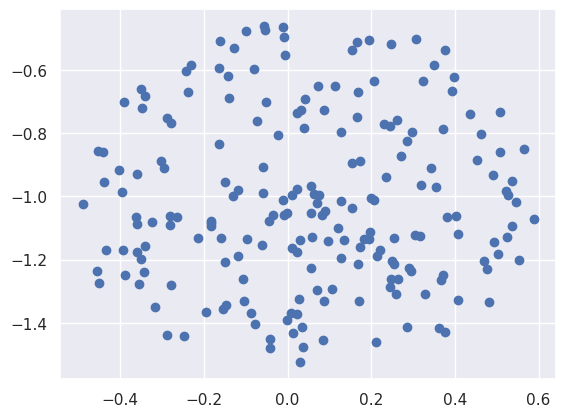

In [ ]:
plt.scatter(flattened_X[:,0],flattened_X[:,1])

In [ ]:
flattened_X, model = radially_flatten_with_ae(neighbs[-1]['X'], return_model=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.


<matplotlib.collections.PathCollection>

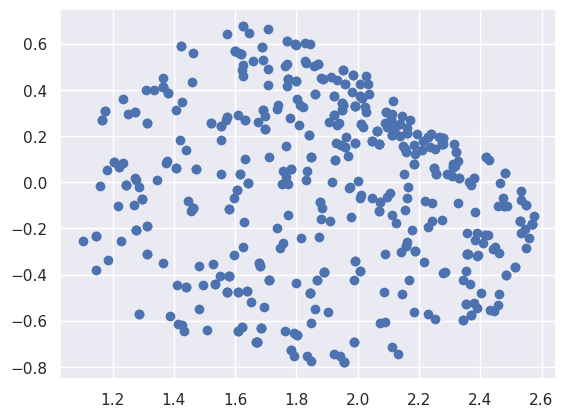

In [ ]:
plt.scatter(flattened_X[:,0],flattened_X[:,1])

In [ ]:
flattened_X, model = radially_flatten_with_ae(neighbs[3]['X'], return_model=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.


<matplotlib.collections.PathCollection>

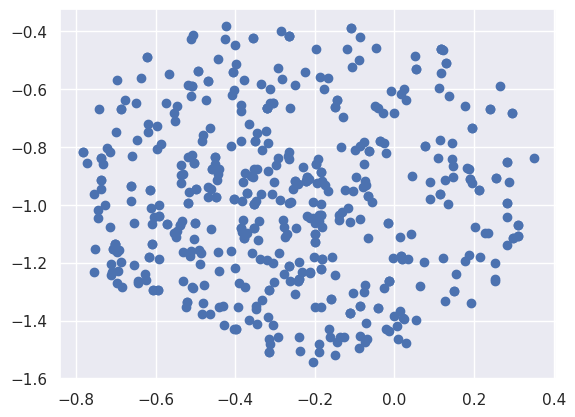

In [ ]:
plt.scatter(flattened_X[:,0],flattened_X[:,1])

## Saddles

In [ ]:
from diffusion_curvature.datasets import rejection_sample_from_saddle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
X, ks = rejection_sample_from_saddle(500, intensity=1)

In [ ]:
emb_op = HeatGeo(knn=5)
emb = emb_op.fit_transform(X)
D = emb_op.dist

NameError: name 'HeatGeo' is not defined

In [ ]:
np.max(D[0])

27.98313356554173

In [ ]:
np.mean(D[0])

20.983539815426397

In [ ]:
np.min(D[0])

NameError: name 'np' is not defined

In [ ]:
D[0]

array([10.69181414, 18.99653962, 21.33414439, 25.37132696, 21.86110484,
       24.10666844, 21.15375206, 18.11934759, 16.64377449, 24.17134964,
       21.73472577, 25.66996035, 22.81311871, 16.15429952, 26.88190132,
       22.78990079, 25.97346191, 26.40307129, 27.15099021, 14.58359874,
       20.74840472, 15.50408106, 24.32343968, 20.98118021, 15.12899621,
       20.54814012, 14.28303896, 14.94480967, 23.4754201 , 16.62920501,
       25.53357199, 20.96555444, 22.06711934, 13.96279452, 23.79422077,
       25.81586294, 17.84790102, 26.42848857, 16.45878063, 23.35707807,
       11.38351016, 23.75663646, 26.14204797, 26.39422467, 19.87675941,
       19.70111959, 21.67459957, 20.45104123, 18.91149117, 24.03066919,
       21.08584509, 12.33147995, 21.76546997, 12.09467221, 26.00009104,
       14.37423018, 20.00630439, 17.97027997, 17.43227376, 19.0634626 ,
       20.86860967, 25.16548132, 10.68152928, 14.97425054, 23.9596992 ,
       26.04870251, 23.81946491, 25.30293891, 24.2640229 , 25.71

In [ ]:
X_restrict = X[D[0] < 25]

In [ ]:
plot_3d(X_restrict,X_restrict[:,0], use_plotly=True)

In [ ]:
X = X_restrict

In [ ]:
trainloader = dataloader_for_local_neighborhood_flattening(X, D, central_idx=0, batch_size=64)
train_sample = next(iter(trainloader))
# Initialize model and trainer
affinity_weight = 1
distance_weight = 1
reconstruction_weight = 0
model = RadialFlatteningAutoencoder(
    input_dim = train_sample['x'].shape[1],
    intrinsic_dim = 2,
    reconstruction_weight = reconstruction_weight,
    distance_weight = distance_weight,
    affinity_weight = affinity_weight,
    learning_rate = 1e-5
    )
early_stopping = EarlyStopping('val_loss', patience=100)
trainer = Trainer(
    max_epochs=20,
    # accelerator='cuda',
    # callbacks=],
    # use_distributed_sampler=False
    )
trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    # val_dataloaders=testloader,
)
embeddings = model.encoder(trainloader.dataset.pointcloud).cpu().detach().numpy()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/piriac/mambaforge/envs/diffusion-curvature-jax/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | KLD     | KLDivLoss  | 0     
1 | encoder | Sequential | 42.3 K
2 | decoder | Sequential | 42.3 K
---------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K

Training: |          | 0/? [00:00<?, ?it/s]

/home/piriac/mambaforge/envs/diffusion-curvature-jax/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

`Trainer.fit` stopped: `max_epochs=20` reached.


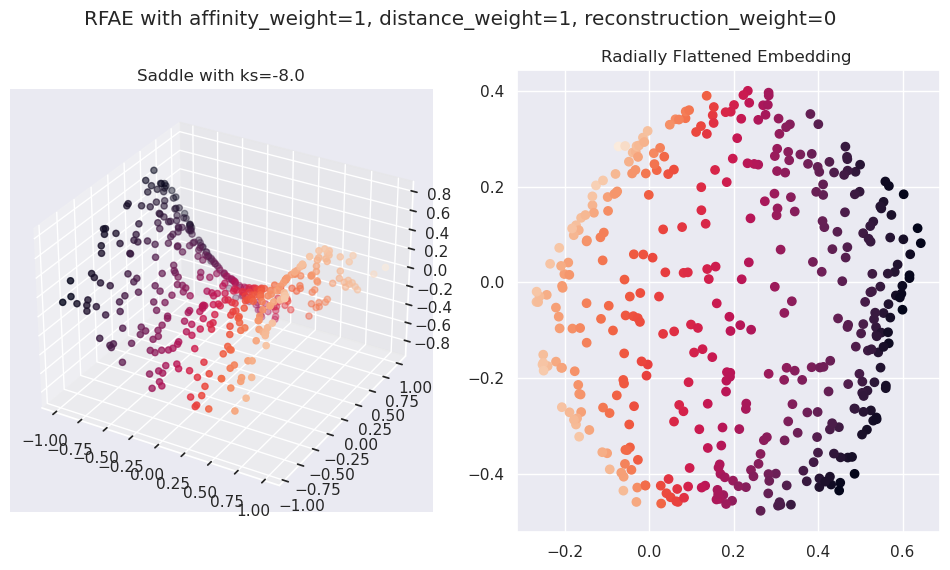

In [ ]:
# Create figure and subplots
fig = plt.figure(figsize=(12, 6))

# 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = X[:,0])
ax1.set_title(f'Saddle with {ks=}')

# 2D scatter plot
ax2 = fig.add_subplot(122)
ax2.scatter(embeddings[:, 0], embeddings[:, 1], c = X[:,0])
ax2.set_title('Radially Flattened Embedding ')

fig.suptitle(f"RFAE with {affinity_weight=}, {distance_weight=}, {reconstruction_weight=}")
# Display the plot
plt.show()


In [ ]:
X_flattened = radially_flatten_with_ae(X, sigma=0.5, affinity_weight=1)

Using s_gd2 for MDS. None


MisconfigurationException: `CUDAAccelerator` can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

<matplotlib.collections.PathCollection>

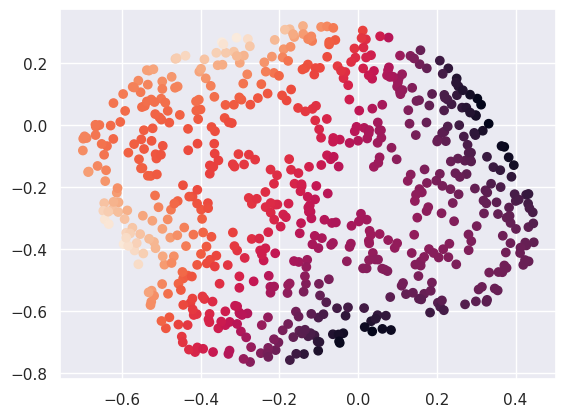

In [ ]:
plt.scatter(X_flattened[:,0], X_flattened[:,1],c=X[:,0])

The results seem to vary a good deal depending on the sigma value used. If sigma is too small, it looks t-sneely-like, with local neighborhoods overwhelming the loss. However, if sigma is too large, sigma equals one, for example, then the data gets split into two, due to the need to prevent embedding the top and bottom of the saddle too close together.

In [ ]:
X_sigmas = {}
sigmas = np.linspace(0,1,10)
# create embedding for each sigma

## Saddles in a Cylinder

In [ ]:
from diffusion_curvature.datasets import rejection_sample_from_saddle

In [ ]:
X, ks = rejection_sample_from_saddle(n_samples=5000, intensity=1)
X = X[np.linalg.norm(X[:,:2],axis=-1) < 1]

In [ ]:
X.shape

(3902, 3)

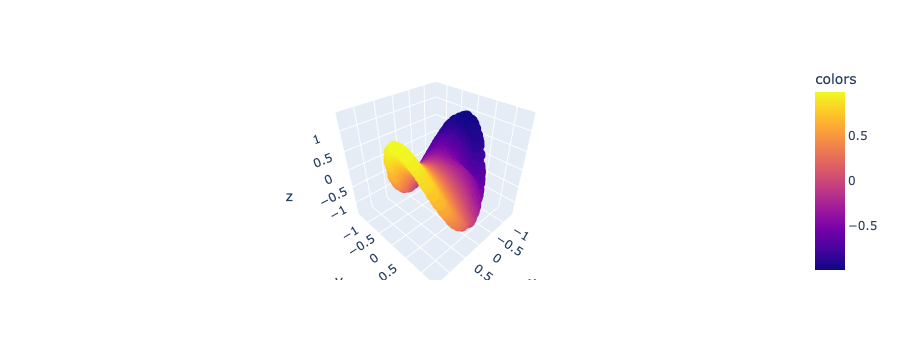

In [ ]:
plot_3d(X,X[:,0], use_plotly=True)

In [ ]:
nodes_near_center = [np.sum((np.linalg.norm(X - x, axis=-1) < 0.1).astype(int)) for x in X]

<matplotlib.collections.PathCollection>

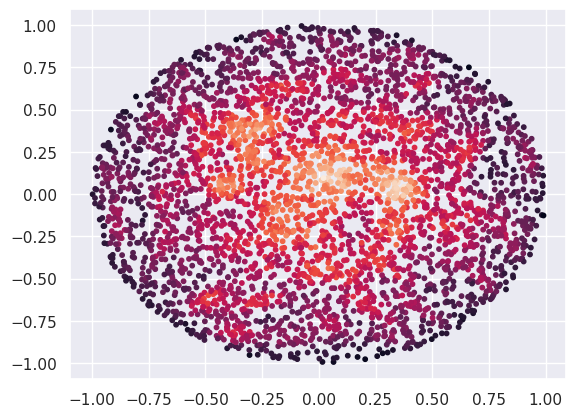

In [ ]:
plt.scatter(X[:,0],X[:,1],c=nodes_near_center,s=10,)

In [ ]:
X_flattened = radially_flatten_with_ae(X, sigma=0.5, affinity_weight=1)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.


<matplotlib.collections.PathCollection>

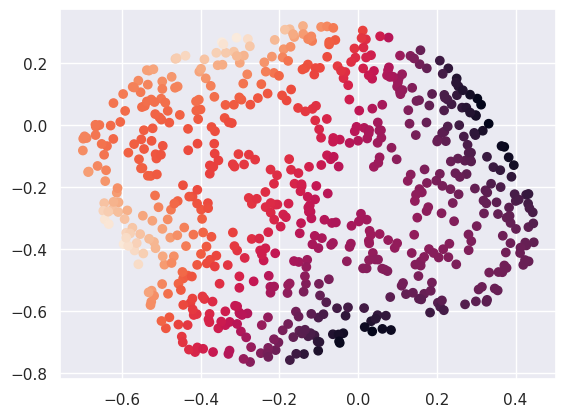

In [ ]:
plt.scatter(X_flattened[:,0], X_flattened[:,1],c=X[:,0])

The results seem to vary a good deal depending on the sigma value used. If sigma is too small, it looks t-sneely-like, with local neighborhoods overwhelming the loss. However, if sigma is too large, sigma equals one, for example, then the data gets split into two, due to the need to prevent embedding the top and bottom of the saddle too close together.

In [ ]:
X_sigmas = {}
sigmas = np.linspace(0,1,10)
# create embedding for each sigma

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

 WARN pixi::project::manifest: BETA feature `[pypi-dependencies]` enabled!

Please report any and all issues here:

	https://github.com/prefix-dev/pixi.

Turn this warning off by setting the environment variable `PIXI_BETA_WARNING_OFF` to `true`.

✨ Pixi task: nbdev_export                                           
/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/env/lib/python3.11/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/nbs/experiments/Curvature from Flattening.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
